## Binary logistic regression

Written by Jess Breda July 2023

In [9]:
import numpy as np
from scipy.optimize import minimize
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold

Steps
-----
1. generate the dataset
2. Define cost & gradient fx
3. Initialize weights & run optimization
4. Visualize

## Dimensions & Assumptions

$ W \in (D + 1) \text{ x } C $

$ X \in N \text{ x } (D + 1) $

$ Y \in N \text{ x } C $

where

$ D = \text{number of features}$

$ C = \text{number of classes}$

$ N = \text {number of samples (i.e trials)}$

Note $W = C$ (not $C-1$), due to future assumptions about Psytrack $\sigma_c$ updates. This allows for independent sigmas. Perhaps hit and miss ($\sigma_{1}, \sigma_{2}$), have smilar sigmas but violations ($\sigma_3$), do not.

Using the Murphy text as a guide, note that $logits = X \cdot W = A$.


### 1. Generate Data

In [10]:
def stable_softmax(logits):
    # use log-sum-exp for numerical stability
    exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))

    # sum over classes & normalize
    sum_exp = np.sum(exp_logits, axis=1, keepdims=True)
    return exp_logits / sum_exp


N = 10000  # Number of samples
D = 4  # Number of features
C = 3  # Number of classes

# Generate random feature values
X = np.random.randn(N, D)
X_with_bias = np.c_[np.ones(N), X]  # bias column

# Generate random true weights (including the bias coefficient)
true_W = np.random.rand(D + 1, C)

# Generate target labels (on hot encoded) using multinomial logistic function
A = X_with_bias @ true_W
P = stable_softmax(A)
Y = np.array([np.random.multinomial(1, n) for n in P])

print(f"Generated {N} samples with {D} features and {C} classes")
print(f"W is {true_W.shape} \nX is {X_with_bias.shape} \nY is {Y.shape}")

Generated 10000 samples with 4 features and 3 classes
W is (5, 3) 
X is (10000, 5) 
Y is (10000, 3)


### 2. Define cost & gradient functions

Note, for the long term goal of applying to psytrack, keeping W = K weights These are passed into scipys' `minimize` function. Note $X$ includes a first bias column of 1s and $y_{ic}$ is one-hot encoded.

1. Probabilities given softmax

$$ p_{ic} = \frac{\exp(a_{ic})}{\sum_{j=1} ^{C}\exp(a_{ij})} $$
$$ a_{ic} = x_i \cdot w_c $$

2. Cost Function:

$$ \text{{nll}} = -\sum_{i=1} ^{N}\sum_{c=1} ^{C}y_{ic} a_{ic} + \log(\sum_{j=1} ^{C}\exp(a_{ij}))$$
$$ \text{{nll}} = -\sum_{i=1} ^{N}\sum_{c=1} ^{C}y_{ic} \log(p_{ic}) $$

3. Gradient

$$\nabla \text{nll}_W = -\sum_{i=1} ^{N}(p_{ic} - y_{ic})x_i$$




In [11]:
def log_sum_exp(logits):
    """
    Compute the log of the sum of exponentials in a
    numerically stable way by subtracting off the largest
    logit.
    """
    max_logits = np.max(logits, axis=1, keepdims=True)
    return (
        np.log(np.sum(np.exp(logits - max_logits), axis=1, keepdims=True)) + max_logits
    )


def multiclass_logistic_cost(W, X, Y, sigma=None):
    """
    Compute the negative log-likelihood for multi-class
    logistic regression with L2 regularization (or MAP).

    params:
    ------
    W: Weights matrix of shape (D+1, C)
    X: Data matrix of shape (N, D+1)
    Y: One-hot encoded labels of shape (N, C)
    sigma : float (default: None)
        Standard deviation of Gaussian prior, if None
        no regularization is applied.

    Returns:
    - nll: Regularized negative log-likelihood
    """

    logits = X @ W

    if sigma:
        penalty = 1 / (2 * sigma**2) * np.trace(W[1:, :].T @ W[1:, :])
    else:
        penalty = 0

    nll = -np.sum(Y * logits) + np.sum(log_sum_exp(logits)) + penalty
    return nll


def multiclass_logistic_gradient(W, X, Y, sigma=None):
    """
    Compute the gradient of the negative log-likelihood for
    multi-class logistic regression with L2 regularization (or MAP).

    params:
    ------
    W: Weights matrix of shape (D+1, C)
    X: Data matrix of shape (N, D+1)
    Y: One-hot encoded labels of shape (N, C)
    sigma : float (default: None)
        Standard deviation of Gaussian prior, if None
        no regularization is applied.

    Returns:
    - gradient : Gradient of shape (D+1, C)
    """

    logits = X @ W
    P = stable_softmax(logits)

    if sigma:
        penalty_gradient = W / sigma**2
        penalty_gradient[0, :] = 0  # No penalty for bias
    else:
        penalty_gradient = 0

    gradient = X.T @ (P - Y) + penalty_gradient
    return gradient


def compute_numerical_gradient(func, W, epsilon=1e-5):
    """
    Compute the numerical gradient of a function using the two-point formula.

    params
    ------
    func: The function to compute the gradient for.
    W: Point to compute the gradient at.
    epsilon: A small perturbation value for computing the gradient.

    returns
    -------
    gradient: Numerical gradient matrix.
    """
    num_grad = np.zeros_like(W)
    perturb = np.zeros_like(W)
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            perturb[i, j] = epsilon
            loss1 = func(W - perturb)
            loss2 = func(W + perturb)
            num_grad[i, j] = (loss2 - loss1) / (2 * epsilon)
            perturb[i, j] = 0

    return num_grad


# Compute the analytical gradient using the provided function
analytical_gradient = multiclass_logistic_gradient(true_W, X_with_bias, Y)

# Compute the numerical gradient for the cost function
numerical_gradient = compute_numerical_gradient(
    lambda W: multiclass_logistic_cost(W, X_with_bias, Y), true_W
)


# Calculate the difference between the analytical and numerical gradients
gradient_difference = np.linalg.norm(analytical_gradient - numerical_gradient)
print(f"gradient_difference is {gradient_difference}")

gradient_difference is 4.87566968551149e-07


In [12]:
# wrapper functions since minimize() needs a flat W vector
def cost_function_to_minimize(W_flat, X, Y, sigma=None):
    W_matrix = W_flat.reshape(D + 1, C)
    return multiclass_logistic_cost(W_matrix, X, Y, sigma)


def gradient_function_to_minimize(W_flat, X, Y, sigma=None):
    W_matrix = W_flat.reshape(D + 1, C)
    grad_matrix = multiclass_logistic_gradient(W_matrix, X, Y, sigma)
    return grad_matrix.flatten()

### 3. Initialize Weights & Optimize

L-BFGS-B versus L-BFGS versus BFGS.

**BFGS:** is a quasi-newton method used for optimization that avoids the costly computation of the Hessian. It approximates the inverse Hessian via gradient updates.

**L-BFGS**: is the limited-memory version of BFGS, doesn't store the full Hessian matrix (or inverse), but instead a subset of vectors that represent this matrix

**L-BFGS-B**: is limited memory version + "bounds". You can implemented bound constraints on the variables being optimized to help minimized the search space. If this is implemented without the `bounds` argument, it is the same as L-BFGS.

In [13]:
# Initial weights
initial_W_flat = np.zeros((D + 1) * C)
sigma = 0.2

# Optimization using L-BFGS-B
result = minimize(
    fun=cost_function_to_minimize,
    x0=initial_W_flat,
    args=(X_with_bias, Y, sigma),
    method="BFGS",
    jac=gradient_function_to_minimize,
    options={"disp": True, "maxiter": 10000},
)
optimized_W = result.x.reshape(D + 1, C)

Optimization terminated successfully.
         Current function value: 9981.359568
         Iterations: 21
         Function evaluations: 31
         Gradient evaluations: 31


In [14]:
# summarize the result
print("Status : %s" % result["message"])
print("Total Evaluations: %d" % result["nfev"])

Status : Optimization terminated successfully.
Total Evaluations: 31


In [15]:
def plot_weight_differences(true_W, optimized_W):
    """
    Plot the differences between consecutive weights for both true and optimized weights.

    Parameters:
    - true_W: true weights
    - optimized_W: weights obtained after optimization

    Returns:
    - plots the differences.
    """

    # Number of classes
    D_w_bias = true_W.shape[0]
    C = true_W.shape[1]

    # labels / colors
    feature_and_bias_labels = np.arange(D_w_bias)
    colors = sns.color_palette("rocket", n_colors=C - 1).as_hex()

    fig, ax = plt.subplots(figsize=(10, 6))
    for c in range(C - 1):
        ax.plot(
            feature_and_bias_labels,
            true_W[:, c] - true_W[:, c + 1],
            label=f"True Weights {c+1} - {c+2}",
            color=colors[c],
            marker="o",
        )
        # Plotting the true weights
        # plt.plot(true_W[:, i] - true_W[:, i + 1], label=f"True Weights {i+1} - {i+2}")
        ax.plot(
            feature_and_bias_labels,
            optimized_W[:, c] - optimized_W[:, c + 1],
            label=f"Optimized Weights {c+1} - {c+2}",
            color=colors[c],
            marker="o",
            linestyle="dashed",
        )

    plt.legend()
    ax.set_title("Difference Between Consecutive Weights")

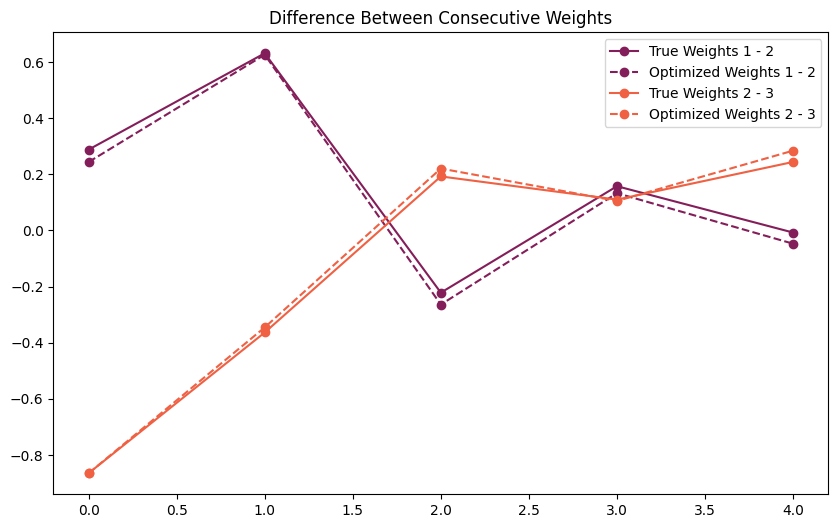

In [16]:
plot_weight_differences(true_W, optimized_W)

## Cross Validation for MAP $\sigma$



### 1. Generate data

In [17]:
N = 10000  # Number of samples
D = 4  # Number of features
C = 3  # Number of classes

# Generate random feature values
X = np.random.randn(N, D)
X_with_bias = np.c_[np.ones(N), X]  # bias column

# Generate random true weights (including the bias coefficient)
true_W = np.random.rand(D + 1, C)
true_sigma = 1  # np.random.rand(1)

# Generate target labels (on hot encoded) using multinomial logistic function
A = X_with_bias @ true_W
P = stable_softmax(A)
Y = np.array([np.random.multinomial(1, n) for n in P])

print(f"Generated {N} samples with {D} features and {C} classes")
print(f"W is {true_W.shape} \nX is {X_with_bias.shape} \nY is {Y.shape}")

Generated 10000 samples with 4 features and 3 classes
W is (5, 3) 
X is (10000, 5) 
Y is (10000, 3)


### 2. Define CV functions

In [18]:
def perform_cross_validation(X, Y, sigma, k=5):
    """
    Perform k-fold cross validation.
    Return the average validation error.
    """
    folds = generate_folds(X, Y, k)
    total_error = 0

    for train_index, test_index in folds:
        total_error += train_and_validate_on_fold(train_index, test_index, X, Y, sigma)

    return total_error / k


def train_and_validate_on_fold(train_index, test_index, X, Y, sigma):
    """
    Function to train and validate on a given fold's train and test indices.

    params
    ------
    train_index: The indices of the training set for a single fold.
    test_index: The indices of the test set for a single fold.
    X: Data matrix of shape (N, D+1)
    Y: One-hot encoded labels of shape (N, C)

    returns
    -------
    error : float
        mean squared error of the model on the test set of single fold
    """
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    initial_W_flat = np.zeros((D + 1) * C)

    result = minimize(
        fun=cost_function_to_minimize,
        x0=initial_W_flat,
        args=(X_train, Y_train, sigma),
        method="BFGS",
        jac=gradient_function_to_minimize,
        options={"disp": False, "maxiter": 10000},
    )

    optimized_W = result.x.reshape(D + 1, C)

    logits = X_test @ optimized_W
    probs = stable_softmax(logits)
    predicted_Y = np.argmax(probs, axis=1)
    true_Y = np.argmax(Y_test, axis=1)

    error = np.mean(predicted_Y != true_Y)
    return error


def generate_folds(X, Y, k):
    """
    Split the data into k folds

    params
    ------
    X: Data matrix of shape (N, D+1)
    Y: One-hot encoded labels of shape (N, C)

    returns
    --------
    List of len = k where each element is a tuple of (train, test)
    pairs for fold ik where train and test are index arrays.
    """
    kf = KFold(n_splits=k, shuffle=True)
    return [(train_index, test_index) for train_index, test_index in kf.split(X)]

### Run Cross Validation of $\sigma$ 

In [55]:
sigma_values = np.array([0.1, 0.2, 0.4, 0.8, 1, 2])
sigma_values

array([0.1, 0.2, 0.4, 0.8, 1. , 2. ])

In [64]:
errors = []

for sigma in sigma_values:
    avg_error = perform_cross_validation(X_with_bias, Y, sigma)
    errors.append(avg_error)

optimal_sigma = sigma_values[np.argmin(errors)]

In [54]:
def plot_cv_sigma(sigma_values, optimal_sigma, true_sigma):
    fig, ax = plt.subplots(figsize=(8, 4))

    ax.plot(sigma_values, errors, "-o", color="black")
    ax.axvline(
        x=true_sigma, color="red", linestyle="--", label=f"True Sigma: {true_sigma}"
    )
    ax.axvline(
        x=optimal_sigma,
        color="gray",
        linestyle="--",
        label=f"Optimal Sigma: {optimal_sigma}",
    )

    ax.set(
        title="Cross-validation of MAP $\sigma$",
        xlabel="$\sigma$",
        ylabel="Average CV Error",
    )
    plt.legend()
    plt.grid(True)

    return None

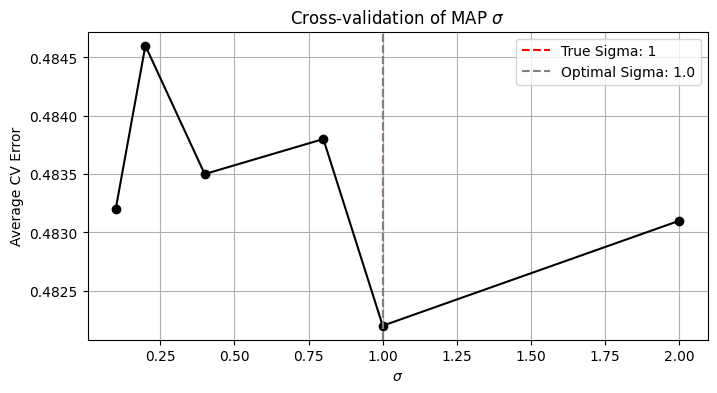

In [65]:
plot_cv_sigma(sigma_values, optimal_sigma, true_sigma)